In [4]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
# !ls german-traffic-signs
# csv of sign names, and three pickle files

import pickle

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
    X_train, y_train = train_data['features'], train_data['labels']
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
    X_val, y_val = val_data['features'], val_data['labels']
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    X_test, y_test = test_data['features'], test_data['labels']

In [6]:
# (num_images, x, y, depth)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

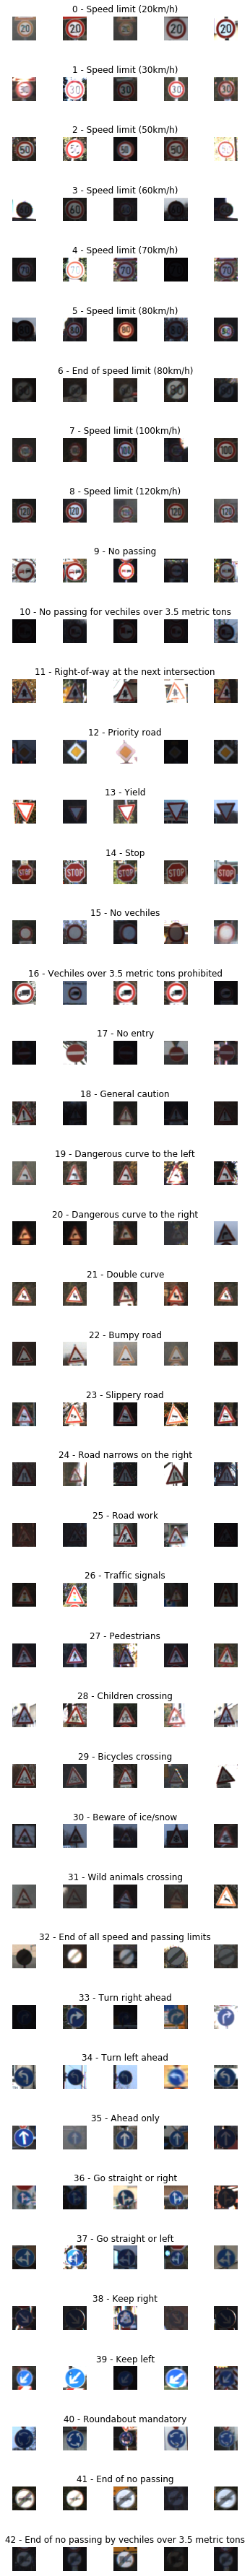

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
# print(data)

num_of_samples = []
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows(): # (index, Series)
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

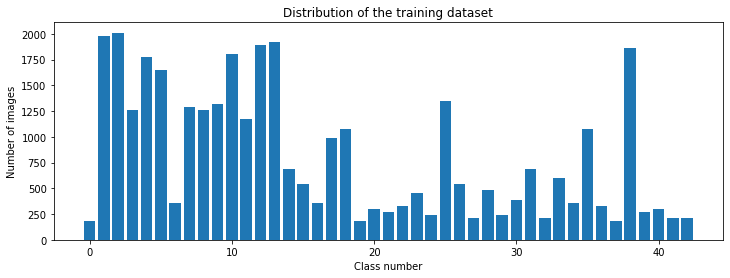

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)


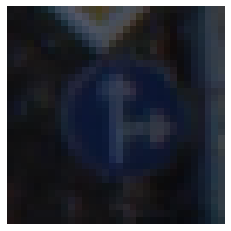

In [11]:
import cv2

image = X_train[1000]
label = y_train[1000]

def plot_image(img):
    plt.imshow(img)
    plt.axis('off')
    print(img.shape)

plot_image(image)

(32, 32)


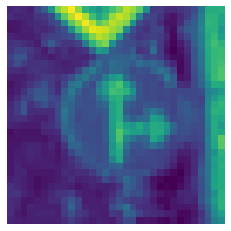

In [12]:
def grayscale(img):
    # reduce depth from 3 to 1, less network parameters (more efficient)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

grayscale_image = grayscale(image)
plot_image(grayscale_image)

(32, 32)


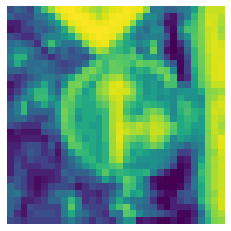

In [13]:
def equalize(img):
    return cv2.equalizeHist(img)

equalized_image = equalize(grayscale_image)
plot_image(equalized_image)

In [0]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

In [26]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

print(X_train.shape)
print(X_test.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             zoom_range=0.2, 
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(X_train)


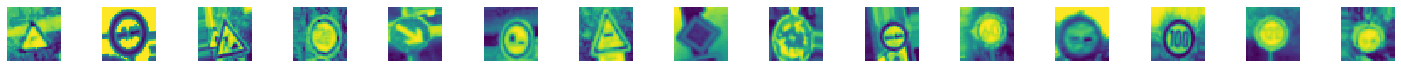

In [42]:
batches = datagen.flow(X_train, y_train, batch_size=20, shuffle=True)

X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis('off')

In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(rate=0.5))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
model = modified_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

In [45]:
# history = model.fit(X_train, y_train, epochs=15, validation_data=[X_val, y_val], batch_size=400, verbose=1, shuffle=1)
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.2027 - acc: 0.9376 - val_loss: 0.0374 - val_acc: 0.9875
Epoch 2/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1759 - acc: 0.9460 - val_loss: 0.0279 - val_acc: 0.9909
Epoch 3/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1559 - acc: 0.9522 - val_loss: 0.0376 - val_acc: 0.9889
Epoch 4/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1483 - acc: 0.9556 - val_loss: 0.0197 - val_acc: 0.9941
Epoch 5/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1346 - acc: 0.9593 - val_loss: 0.0189 - val_acc: 0.9934
Epoch 6/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1311 - acc: 0.9603 - val_loss: 0.0190 - val_acc: 0.9937
Epoch 7/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.1230 - acc: 0.9630 - val_loss: 0.0176 - val_acc: 0.9937
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

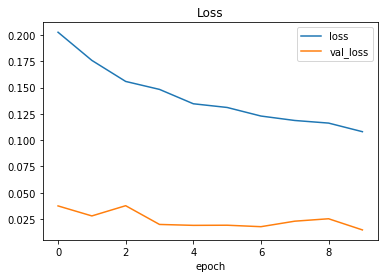

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

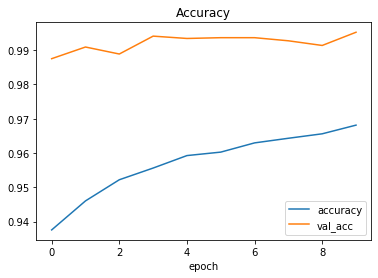

In [47]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['accuracy', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

<class 'list'>
Test Score: 0.11646980436043909
Test Accuracy: 0.9665874901501225


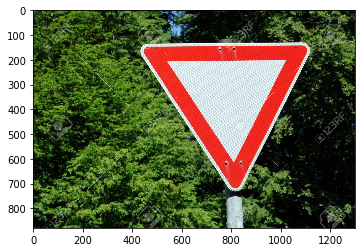

In [51]:
# fetch image
import requests
from PIL import Image
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
# url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


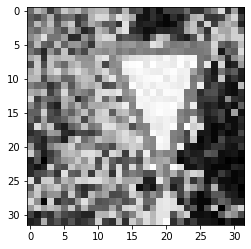

In [52]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 

In [53]:
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [13]
